# Training an Agent in the Parking Scenario

This notebook introduce how to train an agent within the officially developed traffic scenario [envs/parking.py](https://github.com/WoodOxen/tactics2d/tree/master/tactics2d/envs). This environment can generate a bay or parallel parking spot and randomize the start position of the vehicle. The agent is trained to park the vehicle into the parking spot.

## Install dependencies

**This notebook is using pygame to render the environment. You may need to download the notebook and run it locally.**

1. Download this notebook.

2. Install the dependencies by running the following command in the terminal:

    ```shell
    git clone git@github.com:SCP-CN-001/rllib.git
    ```

3. Run the commands in the next cell to install the dependencies.

In [1]:
%%capture
# TODO: this is a temporary solution to install the package from the repo
# TODO: remove this cell and install the package from pypi when 0.1.7 is released
# !pip install tactics2d
!pip install torch

In [2]:
import sys

sys.path.append(".")
sys.path.append("./rllib")
sys.path.append("../..")
sys.path.append("../../tactics2d")

import os
import time
from collections import deque
import heapq
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium import Wrapper
import numpy as np
from shapely.geometry import LinearRing, LineString, Point
import torch
from torch.distributions import Normal
from torch.utils.tensorboard import SummaryWriter

from rllib.algorithms.ppo import *
from tactics2d.envs import ParkingEnv
from tactics2d.math.interpolate import ReedsShepp
from tactics2d.traffic.status import ScenarioStatus

2024-05-22 17:46:54.029230: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 17:46:54.616952: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Define the environment

In [3]:
# the proportion of the type of parking lot,
# 0 means all scenarios are parallel parking, 1 means all scenarios are vertical parking
type_proportion = 1.0
# the render mode, "rgb_array" means render the scene to a numpy array, "human" means render the scene to a window
render_mode = ["rgb_array", "human"][1]
render_fps = 50
# the max step of one episode
max_step = 1000
env = ParkingEnv(
    type_proportion=type_proportion,
    render_mode=render_mode,
    render_fps=render_fps,
    max_step=max_step,
)

## Define a env wrapper

To train our reinforcement learning agents, we often need to define vectorized representations of states and actions for interacting with the environment. Therefore, we use a wrapper to encapsulate the original environment.

In [4]:
num_lidar_rays = env.scenario_manager._lidar_line  # 360
lidr_obs_shape = num_lidar_rays // 3  # 120
lidar_range = env.scenario_manager._lidar_range


# the wrapper is used to preprocess the observation and action
class ParkingWrapper(Wrapper):
    def __init__(self, env: gym.Env):
        super().__init__(env)
        observation_shape = (
            lidr_obs_shape + 6
        )  # 120: lidar obs size. 6: size of additional features we add
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf, shape=(observation_shape, 1), dtype=np.float32
        )

    def _preprocess_action(self, action):
        action = np.array(action, dtype=np.float32)
        action = np.clip(action, -1, 1)
        action_space = self.env.action_space
        action = (
            action * (action_space.high - action_space.low) / 2
            + (action_space.high + action_space.low) / 2
        )
        return action

    def _preprocess_observation(self, info):
        lidar_info = np.clip(info["lidar"], 0, 20)
        lidar_info = lidar_info[
            ::3
        ]  # we downsample the lidar data from 360 to 120 to feed into the model
        lidar_feature = lidar_info / 20.0  # normalize the lidar data to [0, 1]
        other_feature = np.array(
            [
                info["diff_position"] / 10.0,  # normalize the distance to target position
                np.cos(info["diff_angle"]),
                np.sin(info["diff_angle"]),
                np.cos(info["diff_heading"]),
                np.sin(info["diff_heading"]),
                info["state"].speed,
            ]
        )

        observation = np.concatenate([lidar_feature, other_feature])
        return observation

    def reset(self, seed: int = None, options: dict = None):
        _, info = self.env.reset(seed, options)
        custom_observation = self._preprocess_observation(info)
        return custom_observation, info

    def step(self, action):
        action = self._preprocess_action(action)
        _, reward, terminated, truncated, info = self.env.step(action)
        custom_observation = self._preprocess_observation(info)

        return custom_observation, reward, terminated, truncated, info

## Planner using Reeds-Shepp Curves

Before training a reinforcement learning (RL) agent, we first implement a geometry-based planner using Reeds-Sheep (RS) curves. Since the basic RS method does not account for obstacles, in the `RSPlanner`, we attempt to find a viable path that avoids collisions with obstacles detected by LiDAR, connecting the vehicle’s current position to the target.

In [5]:
# In practice we do not let the vehicle turn to the maximum steering angle
STEER_RATIO = 0.98


class RSPlanner:
    # use Reeds-Shepp curve to plan the collision-free path
    def __init__(self, vehicle, lidar_num, lidar_range=lidar_range) -> None:
        self.radius = vehicle.wheel_base / np.tan(vehicle.steer_range[1] * STEER_RATIO)  # TODO
        self.vehicle_box = vehicle.geometry
        self.lidar_num = lidar_num
        self.lidar_range = lidar_range
        # the minimum distance between the vehicle's bounding box and the rear wheel center
        self.vehicle_base = self.init_vehicle_base()
        self.center_shift = 0.5 * vehicle.length - vehicle.rear_overhang
        self.start_pos = [0, 0, 0]
        self.move_vehicle_center()
        self.distance_tolerance = 0.05  # the distance tolerance to the obstacles
        self.threshold_distance = (
            lidar_range - 5.0
        )  # the threshold of distance to the target to execute the rs path
        self.rs_planner = ReedsShepp(self.radius)

    def init_vehicle_base(self):
        self.lidar_lines = []
        lidar_num = self.lidar_num
        lidar_range = self.lidar_range
        for a in range(lidar_num):
            self.lidar_lines.append(
                LineString(
                    (
                        (0, 0),
                        (
                            np.cos(a * np.pi / lidar_num * 2) * lidar_range,
                            np.sin(a * np.pi / lidar_num * 2) * lidar_range,
                        ),
                    )
                )
            )
        lidar_base = []
        ORIGIN = Point((0, 0))
        for l in self.lidar_lines:
            distance = l.intersection(self.vehicle_box).distance(ORIGIN)
            lidar_base.append(distance)
        return np.array(lidar_base)

    def move_vehicle_center(self):
        """The rs curve is calculated based on the vehicle's rear wheel center"""
        vehicle_coords = np.array(self.vehicle_box.coords[:4])
        vehicle_coords[:, 0] = vehicle_coords[:, 0] + self.center_shift
        self.vehicle_box = LinearRing(vehicle_coords)

    def get_rs_path(self, info):
        start_x, start_y, start_yaw = self.start_pos
        dest_coords = np.mean(
            np.array(list(info["target_area"].geometry.exterior.coords)[:4]), axis=0
        )
        dest_heading = info["target_heading"]
        ego_pos = [info["state"].x, info["state"].y, info["state"].heading]
        # print("ego_pos", ego_pos)
        # print("dest_pos", dest_coords)
        if self.center_shift != 0:
            dest_coords[0] -= self.center_shift * np.cos(dest_heading)
            dest_coords[1] -= self.center_shift * np.sin(dest_heading)
            ego_pos[0] -= self.center_shift * np.cos(ego_pos[2])
            ego_pos[1] -= self.center_shift * np.sin(ego_pos[2])

        dest_pos = (dest_coords[0], dest_coords[1], dest_heading)
        self.dest_pos = dest_pos
        self.ego_pos = ego_pos
        rel_distance = np.sqrt((dest_pos[0] - ego_pos[0]) ** 2 + (dest_pos[1] - ego_pos[1]) ** 2)
        if rel_distance > self.threshold_distance:
            return None

        rel_angle = np.arctan2(dest_pos[1] - ego_pos[1], dest_pos[0] - ego_pos[0]) - ego_pos[2]
        rel_dest_heading = dest_pos[2] - ego_pos[2]
        goalX, goalY, goalYaw = (
            rel_distance * np.cos(rel_angle),
            rel_distance * np.sin(rel_angle),
            rel_dest_heading,
        )
        #  Find all possible reeds-shepp paths between current and goal node
        reedsSheppPaths = self.rs_planner.get_all_path(
            np.array([start_x, start_y]), start_yaw, np.array([goalX, goalY]), goalYaw
        )

        # Check if reedsSheppPaths is empty
        if not reedsSheppPaths:
            return None

        # Initialize an empty list to act as the priority queue
        costs = []
        # Create a dictionary to map paths to their lengths
        path_lengths = {}

        # Populate the priority queue and the path_lengths dictionary
        for i, path in enumerate(reedsSheppPaths):
            if path is None:
                continue
            heapq.heappush(costs, (path.length, i))  # Push tuple (length, index)
            path_lengths[i] = path.length  # Store path length in dictionary

        # Find the first collision-free path in the priority queue
        min_path_len = -1
        obstacles_params = self.construct_obstacles(info)
        while costs:
            # Pop the tuple with the minimum length
            _, index = heapq.heappop(costs)
            path = reedsSheppPaths[index]
            if min_path_len < 0:
                min_path_len = path.length
            if path.length > 2 * min_path_len:
                break

            path.get_curve_line(np.array([start_x, start_y]), start_yaw, self.radius, 0.1)
            # print(len(path.curve), path.length, len(path.yaw))
            traj = [[path.curve[k][0], path.curve[k][1], path.yaw[k]] for k in range(len(path.yaw))]
            traj_valid = self.is_traj_valid(traj, obstacles_params)
            if traj_valid:
                return path

        return None

    def plot_rs_path(self, traj, origin=None):
        if origin is None:
            origin = self.ego_pos

        def coord_transform(x, y, yaw, origin):
            # x, y, yaw are in the local coordinate
            phi = np.arctan2(y, x)
            r = np.sqrt(x**2 + y**2)
            x = r * np.cos(phi + origin[2]) + origin[0]
            y = r * np.sin(phi + origin[2]) + origin[1]
            return x, y, yaw + origin[2]

        # make sure x-axis and y-axis have the same scale
        plt.axis("equal")
        cnt = 0
        for x, y, yaw in traj:
            x, y, yaw = coord_transform(x, y, yaw, origin)
            if cnt % 5 == 0:
                vehicle_coords = np.array(self.vehicle_box.coords)
                # rotate and shift the vehicle box
                vehicle_coords = vehicle_coords.dot(
                    np.array([[np.cos(yaw), np.sin(yaw)], [-np.sin(yaw), np.cos(yaw)]])
                ) + np.array([x, y])
                plt.plot(vehicle_coords[:, 0], vehicle_coords[:, 1], "b-")
            cnt += 1
            plt.arrow(x, y, 0.1 * np.cos(yaw), 0.1 * np.sin(yaw), head_width=0.1, head_length=0.1)

        for x, y in self.lidar_pts:
            x, y, _ = coord_transform(x, y, 0, origin)
            plt.scatter(x, y, c="r", s=1)
        plt.show()

    def construct_obstacles(self, info):
        """
        Construct the obstacles as edges based on the lidar observation.
        """
        lidar_obs = info["lidar"]
        lidar_obs = np.clip(lidar_obs, 0.0, self.lidar_range)
        assert len(lidar_obs) == self.lidar_num
        # we minus the lidar_obs by the distance_tolerance to expand the obstacles
        lidar_obs = np.maximum(self.vehicle_base, lidar_obs - self.distance_tolerance)
        angle_vec = np.arange(self.lidar_num) * np.pi / self.lidar_num * 2
        obstacle_edge_x1 = np.cos(angle_vec) * lidar_obs  # (N,)
        obstacle_edge_y1 = np.sin(angle_vec) * lidar_obs
        obstacle_edge_x1 = obstacle_edge_x1 + self.center_shift
        self.lidar_pts = np.array([obstacle_edge_x1, obstacle_edge_y1]).T
        obstacle_edge_coords = np.concatenate(
            (np.expand_dims(obstacle_edge_x1, 1), np.expand_dims(obstacle_edge_y1, 1)), axis=1
        )  # (N, 2)
        shifted_obstacle_coords = obstacle_edge_coords.copy()
        shifted_obstacle_coords[:-1] = obstacle_edge_coords[1:]
        shifted_obstacle_coords[-1] = obstacle_edge_coords[0]
        obstacle_edge_x2 = shifted_obstacle_coords[:, 0].reshape(1, -1)
        obstacle_edge_y2 = shifted_obstacle_coords[:, 1].reshape(1, -1)
        obstacle_edge_x1 = obstacle_edge_x1.reshape(1, -1)
        obstacle_edge_y1 = obstacle_edge_y1.reshape(1, -1)

        # remove the edges intersects with target area
        collide_map = self.is_traj_valid(
            [self.dest_pos],
            [obstacle_edge_x1, obstacle_edge_x2, obstacle_edge_y1, obstacle_edge_y2],
            True,
        )  # (4,E)
        collide_edge = np.sum(collide_map, axis=0).reshape(1, -1)  # (1,E)
        valid_edge_idx = collide_edge == 0
        obstacle_edge_x1 = obstacle_edge_x1[valid_edge_idx].reshape(1, -1)
        obstacle_edge_x2 = obstacle_edge_x2[valid_edge_idx].reshape(1, -1)
        obstacle_edge_y1 = obstacle_edge_y1[valid_edge_idx].reshape(1, -1)
        obstacle_edge_y2 = obstacle_edge_y2[valid_edge_idx].reshape(1, -1)

        return [obstacle_edge_x1, obstacle_edge_x2, obstacle_edge_y1, obstacle_edge_y2]

    def is_traj_valid(self, traj, obstacles_params: list, return_collide_map=False):
        """
        This function is used to check whether the trajectory is collision-free.
        """
        vehicle_box = self.vehicle_box
        car_coords1 = np.array(vehicle_box.coords)[:4]  # (4,2)
        car_coords2 = np.array(vehicle_box.coords)[1:]  # (4,2)
        car_coords_x1 = car_coords1[:, 0].reshape(1, -1)
        car_coords_y1 = car_coords1[:, 1].reshape(1, -1)  # (1,4)
        car_coords_x2 = car_coords2[:, 0].reshape(1, -1)
        car_coords_y2 = car_coords2[:, 1].reshape(1, -1)  # (1,4)
        vxs = np.array([t[0] for t in traj])
        vys = np.array([t[1] for t in traj])
        vthetas = np.array([t[2] for t in traj])
        cos_theta = np.cos(vthetas).reshape(-1, 1)  # (T,1)
        sin_theta = np.sin(vthetas).reshape(-1, 1)
        vehicle_coords_x1 = (
            cos_theta * car_coords_x1 - sin_theta * car_coords_y1 + vxs.reshape(-1, 1)
        )  # (T,4)
        vehicle_coords_y1 = (
            sin_theta * car_coords_x1 + cos_theta * car_coords_y1 + vys.reshape(-1, 1)
        )
        vehicle_coords_x2 = (
            cos_theta * car_coords_x2 - sin_theta * car_coords_y2 + vxs.reshape(-1, 1)
        )  # (T,4)
        vehicle_coords_y2 = (
            sin_theta * car_coords_x2 + cos_theta * car_coords_y2 + vys.reshape(-1, 1)
        )
        vx1s = vehicle_coords_x1.reshape(-1, 1)
        vx2s = vehicle_coords_x2.reshape(-1, 1)
        vy1s = vehicle_coords_y1.reshape(-1, 1)
        vy2s = vehicle_coords_y2.reshape(-1, 1)
        # Line 1: the edges of vehicle box, ax + by + c = 0
        a = (vy2s - vy1s).reshape(-1, 1)  # (4*t,1)
        b = (vx1s - vx2s).reshape(-1, 1)
        c = (vy1s * vx2s - vx1s * vy2s).reshape(-1, 1)

        x1s, x2s, y1s, y2s = obstacles_params
        # Line 2: the edges of obstacles, dx + ey + f = 0
        d = (y2s - y1s).reshape(1, -1)  # (1,E)
        e = (x1s - x2s).reshape(1, -1)
        f = (y1s * x2s - x1s * y2s).reshape(1, -1)

        # calculate the intersections
        det = a * e - b * d  # (4*t, E)
        parallel_line_pos = det == 0  # (4*t, E)
        det[parallel_line_pos] = 1  # temporarily set "1" to avoid "divided by zero"
        raw_x = (b * f - c * e) / det  # (4*t, E)
        raw_y = (c * d - a * f) / det

        collide_map_x = np.ones_like(raw_x, dtype=np.uint8)
        collide_map_y = np.ones_like(raw_x, dtype=np.uint8)
        # the false positive intersections on line L2(not on edge L2)
        tolerance_precision = 1e-4
        collide_map_x[raw_x > np.maximum(x1s, x2s) + tolerance_precision] = 0
        collide_map_x[raw_x < np.minimum(x1s, x2s) - tolerance_precision] = 0
        collide_map_y[raw_y > np.maximum(y1s, y2s) + tolerance_precision] = 0
        collide_map_y[raw_y < np.minimum(y1s, y2s) - tolerance_precision] = 0
        # the false positive intersections on line L1(not on edge L1)
        collide_map_x[raw_x > np.maximum(vx1s, vx2s) + tolerance_precision] = 0
        collide_map_x[raw_x < np.minimum(vx1s, vx2s) - tolerance_precision] = 0
        collide_map_y[raw_y > np.maximum(vy1s, vy2s) + tolerance_precision] = 0
        collide_map_y[raw_y < np.minimum(vy1s, vy2s) - tolerance_precision] = 0

        collide_map = collide_map_x * collide_map_y
        collide_map[parallel_line_pos] = 0
        if return_collide_map:
            return collide_map
        collide = np.sum(collide_map) > 0

        if collide:
            return False
        return True

## Plan the path using Reeds-Shepp Curves

In [6]:
env = ParkingWrapper(env)
path_planner = RSPlanner(env.scenario_manager.agent, num_lidar_rays, lidar_range)
vehicle = env.scenario_manager.agent

/home/rowena/miniconda3/envs/tactics2d/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.scenario_manager to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.scenario_manager` for environment variables or `env.get_wrapper_attr('scenario_manager')` that will search the reminding wrappers.
  logger.warn(


/home/rowena/Documents/tactics2d/docs/tutorial/../../tactics2d/sensor/render_manager.py:209: UserWarning: Sensor 0 is not bound with any participant.
  warnings.warn(f"Sensor {id_} is not bound with any participant.")
/home/rowena/Documents/tactics2d/docs/tutorial/../../tactics2d/sensor/render_manager.py:209: UserWarning: Sensor 1 is not bound with any participant.
  warnings.warn(f"Sensor {id_} is not bound with any participant.")


Trail 0: No valid path
Trail 1: No valid path
Trail 2: Find valid path
Path length:  11.316034816439107


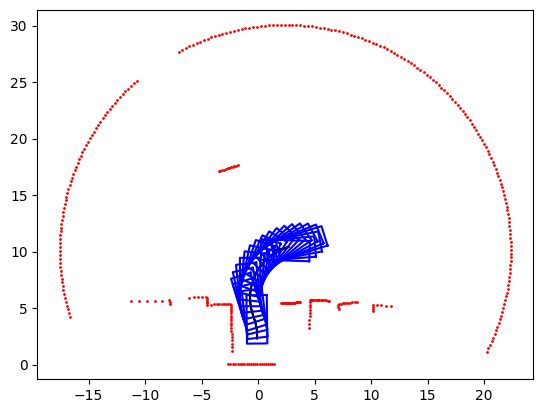

Trail 3: No valid path
Trail 4: No valid path
Trail 5: No valid path
Trail 6: No valid path
Trail 7: Find valid path
Path length:  10.649192354030928


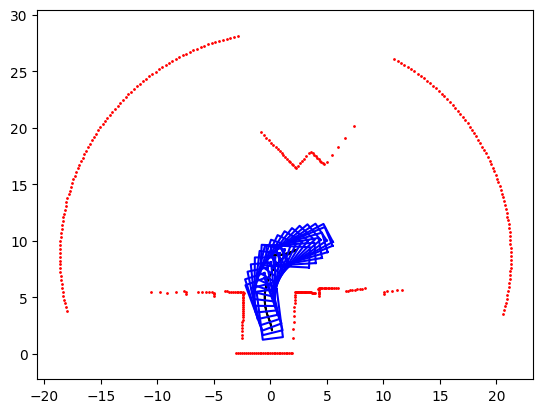

Trail 8: No valid path
Trail 9: No valid path
Panning success rate:  0.2


/home/rowena/Documents/tactics2d/docs/tutorial/../../tactics2d/map/element/map.py:193: UserWarning: Area 0003 already exists! Replacing the area with new data.
  warnings.warn(f"Area {area.id_} already exists! Replacing the area with new data.")


In [7]:
num_trails = 10
num_success = 0
for n in range(num_trails):
    obs, info = env.reset()
    path = path_planner.get_rs_path(info)
    if path is None:
        print("Trail %s: No valid path" % n)
    else:
        num_success += 1
        print("Trail %s: Find valid path" % n)
        start_x, start_y, start_yaw = path_planner.start_pos
        path.get_curve_line(np.array([start_x, start_y]), start_yaw, path_planner.radius, 0.1)
        traj = [[path.curve[k][0], path.curve[k][1], path.yaw[k]] for k in range(len(path.yaw))]
        print("Path length: ", path.length)
        path_planner.plot_rs_path(traj)

print("Panning success rate: ", num_success / num_trails)

## Execute the RS path

We define the simple PID controllers to trace the path generated by the planner.

In [8]:
max_speed = 0.5  # we manually set the max speed in the parking task


class PIDController:
    def __init__(self, target, Kp=0.1, Ki=0.0, Kd=0.0):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.target = target
        self.prev_error = 0
        self.integral = 0

    def update(self, current_value, target=None):
        if target is not None:
            self.target = target
        error = self.target - current_value
        self.integral += error
        derivative = error - self.prev_error
        output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
        self.prev_error = error
        return output

    def reset(self, target=None):
        if target is not None:
            self.target = target
        self.prev_error = 0
        self.integral = 0


def rear_center_coord(center_x, center_y, heading, lr):
    """calculate the rear wheel center position based on the center position and heading angle"""
    x = center_x - lr * np.cos(heading)
    y = center_y - lr * np.sin(heading)
    return x, y, heading


def execute_path_pid(path, env):
    action_type = {"L": 1, "S": 0, "R": -1}
    radius = env.scenario_manager.agent.wheel_base / np.tan(
        env.scenario_manager.agent.steer_range[1] * STEER_RATIO
    )
    env_agent = env.scenario_manager.agent
    physics_model = env.scenario_manager.agent.physics_model
    # max_speed = max_speed
    max_acceleration = physics_model.accel_range[-1]

    actions = []
    for i in range(len(path.actions)):
        steer_normalized = action_type[path.actions[i]]  # [-1,1]
        distance = path.signs[i] * path.segments[i] * radius
        actions.append([steer_normalized, distance])

    accelerate_controller = PIDController(0, 2.0, 0.0, 0.0)
    velocity_controller = PIDController(0, 0.8, 0.0, 0.0)
    steer_controller = PIDController(0, 5.0, 0.0, 0.0)

    def _calculate_target_point(start_x_, start_y_, start_yaw_, steer, distance):
        if steer == 0:
            target_x_ = start_x_ + distance * np.cos(start_yaw_)
            target_y_ = start_y_ + distance * np.sin(start_yaw_)
            target_yaw_ = start_yaw_
            arc_center_x_, arc_center_y_ = None, None
        elif steer == 1:
            arc_center_x_ = start_x_ - radius * np.sin(start_yaw_)
            arc_center_y_ = start_y_ + radius * np.cos(start_yaw_)
            delta_radian = distance / radius
            target_x_ = arc_center_x_ + radius * np.sin(start_yaw_ + delta_radian)
            target_y_ = arc_center_y_ - radius * np.cos(start_yaw_ + delta_radian)
            target_yaw_ = start_yaw_ + delta_radian
        elif steer == -1:
            arc_center_x_ = start_x_ + radius * np.sin(start_yaw_)
            arc_center_y_ = start_y_ - radius * np.cos(start_yaw_)
            delta_radian = distance / radius
            target_x_ = arc_center_x_ + radius * np.sin(-start_yaw_ + delta_radian)
            target_y_ = arc_center_y_ + radius * np.cos(-start_yaw_ + delta_radian)
            target_yaw_ = start_yaw_ - delta_radian

        return target_x_, target_y_, target_yaw_, arc_center_x_, arc_center_y_

    def _calc_pt_error(pt_start, pt_end, pt, heading):
        # calculate the distance from pt to the line defined by pt_start and pt_end
        x1, y1 = pt_start
        x2, y2 = pt_end
        x0, y0 = pt
        yaw = np.arctan2(y2 - y1, x2 - x1)
        orientation = 1 if np.cos(yaw - heading) > 0 else -1
        # if heading is roughly from pt_start to pt_end, then the error should be positive when pt is on the left side of the line
        error_distance_to_line = (y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1
        error_distance_to_line /= np.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)
        error_distance_to_line *= orientation
        return error_distance_to_line

    # calculate target points
    start_state = env_agent.get_state()
    start_x, start_y, start_yaw = start_state.x, start_state.y, start_state.heading
    start_x_, start_y_, start_yaw_ = rear_center_coord(
        start_x, start_y, start_yaw, physics_model.lr
    )
    target_points = []
    arc_centers = []
    for i in range(len(actions)):
        steer, distance = actions[i]
        target_x_, target_y_, target_yaw_, arc_center_x_, arc_center_y_ = _calculate_target_point(
            start_x_, start_y_, start_yaw_, steer, distance
        )
        target_points.append([target_x_, target_y_, target_yaw_])
        arc_centers.append([arc_center_x_, arc_center_y_])
        start_x_, start_y_, start_yaw_ = target_x_, target_y_, target_yaw_

    total_reward = 0
    done = False
    cnt = 0
    for i in range(len(target_points)):
        steer, distance = actions[i]
        base_steer = steer * STEER_RATIO
        vehicle_orientation = np.sign(distance)
        target_x_, target_y_, target_yaw_ = target_points[i]
        arc_center_x_, arc_center_y_ = arc_centers[i]
        curr_state = env_agent.get_state()
        start_x, start_y, start_yaw = curr_state.x, curr_state.y, curr_state.heading
        start_x_, start_y_, start_yaw_ = rear_center_coord(
            start_x, start_y, start_yaw, physics_model.lr
        )
        distance_to_go = np.sqrt((start_x_ - target_x_) ** 2 + (start_y_ - target_y_) ** 2)
        while distance_to_go > 0.02:
            curr_state = env_agent.get_state()
            x, y, yaw, v = curr_state.x, curr_state.y, curr_state.heading, curr_state.speed
            x_, y_, yaw_ = rear_center_coord(x, y, yaw, physics_model.lr)
            distance_to_go = np.sqrt((x_ - target_x_) ** 2 + (y_ - target_y_) ** 2)
            target_v = velocity_controller.update(-distance_to_go * vehicle_orientation, 0)
            target_v = np.clip(target_v, -max_speed, max_speed)
            target_a = accelerate_controller.update(v, target_v)
            target_a = np.clip(target_a, -max_acceleration, max_acceleration)
            if arc_center_x_ is not None:
                error_distance_to_center = (
                    np.sqrt((x_ - arc_center_x_) ** 2 + (y_ - arc_center_y_) ** 2) - radius
                )
                error_distance_to_center *= np.sign(
                    steer
                )  # when the error is positive we want to increase the steer
                target_current_yaw = np.arctan2(
                    y_ - arc_center_y_, x_ - arc_center_x_
                ) + np.pi / 2 * np.sign(steer)
            else:
                target_current_yaw = target_yaw_
                error_distance_to_center = _calc_pt_error(
                    [start_x_, start_y_], [target_x_, target_y_], [x_, y_], yaw_
                )

            error_yaw = -(target_current_yaw - yaw_)
            error_yaw = np.arctan2(np.sin(error_yaw), np.cos(error_yaw))
            total_error = error_distance_to_center + 0.5 * error_yaw
            delta_steer = steer_controller.update(-total_error, 0)
            target_steer = base_steer + delta_steer
            target_steer = np.clip(target_steer, -1, 1)
            action = np.array([target_steer, target_a / max_acceleration])

            _, reward, terminate, truncated, info = env.step(action)
            env.render()
            done = terminate or truncated
            total_reward += reward
            cnt += 1

            if done:
                break

        if done:
            break

    return total_reward, done, info

In [9]:
num_trails = 10
num_success = 0
for n in range(num_trails):
    obs, info = env.reset()
    path = path_planner.get_rs_path(info)
    if path is None:
        print("Trail %s: No valid path" % n)
        pass
    else:
        print("Trail %s: Find valid path" % n)
        total_reward, done, info = execute_path_pid(path, env)
        print("status: ", info["scenario_status"])
        if info["scenario_status"] == ScenarioStatus.COMPLETED:
            num_success += 1
        # break

print("Parking success rate: ", num_success / num_trails)

Trail 0: Find valid path
status:  ScenarioStatus.COMPLETED
Trail 1: No valid path
Trail 2: No valid path
Trail 3: Find valid path


/home/rowena/Documents/tactics2d/docs/tutorial/../../tactics2d/map/element/map.py:193: UserWarning: Area 0007 already exists! Replacing the area with new data.
  warnings.warn(f"Area {area.id_} already exists! Replacing the area with new data.")


status:  ScenarioStatus.COMPLETED
Trail 4: No valid path
Trail 5: No valid path
Trail 6: No valid path
Trail 7: Find valid path


/home/rowena/Documents/tactics2d/docs/tutorial/../../tactics2d/map/element/map.py:193: UserWarning: Area 0008 already exists! Replacing the area with new data.
  warnings.warn(f"Area {area.id_} already exists! Replacing the area with new data.")


status:  ScenarioStatus.COMPLETED
Trail 8: No valid path
Trail 9: No valid path
Parking success rate:  0.3


## Define a hybrid policy agent

Due to the low success rate of directly using RS curves for parking planning, we have developed a hybrid strategy reinforcement learning agent. This agent leverages RS curves to assist in route planning on top of reinforcement learning, which can enhance training efficiency and increase the success rate of parking.

In [10]:
class RSAgent:
    def __init__(
        self,
        path_planner,
        execute_radius,
        dr,
        steer_ratio=STEER_RATIO,
        max_acceleration=2.0,
        max_speed=0.5,
    ):
        self.path_planner = path_planner
        self.max_speed = max_speed
        self.max_acceleration = max_acceleration
        self.steer_ratio = steer_ratio
        self.execute_radius = execute_radius
        self.dr = dr  # the distance between the rear wheel center and the vehicle center
        self.distance_record = []

        self.accelerate_controller = PIDController(0, 2.0, 0.0, 0.0)
        self.velocity_controller = PIDController(0, 0.8, 0.0, 0.0)
        self.steer_controller = PIDController(0, 5.0, 0.0, 0.0)

        self.path_info = {
            "segments": [],
            "target_points": [],
            "arc_centers": [],
            "start_points": [],
        }

    @property
    def executing_rs(self):
        return len(self.path_info["segments"]) > 0

    def _calc_pt_error(self, pt_start, pt_end, pt, heading):
        # calculate the distance from pt to the line defined by pt_start and pt_end
        x1, y1 = pt_start
        x2, y2 = pt_end
        x0, y0 = pt
        yaw = np.arctan2(y2 - y1, x2 - x1)
        orientation = 1 if np.cos(yaw - heading) > 0 else -1
        # if heading is roughly from pt_start to pt_end, then the error should be positive when pt is on the left side of the line
        error_distance_to_line = (y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1
        error_distance_to_line /= np.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)
        error_distance_to_line *= orientation
        return error_distance_to_line

    def _calculate_target_point(self, start_x_, start_y_, start_yaw_, steer, distance):
        radius = self.execute_radius
        if steer == 0:
            target_x_ = start_x_ + distance * np.cos(start_yaw_)
            target_y_ = start_y_ + distance * np.sin(start_yaw_)
            target_yaw_ = start_yaw_
            arc_center_x_, arc_center_y_ = None, None
        elif steer == 1:
            arc_center_x_ = start_x_ - radius * np.sin(start_yaw_)
            arc_center_y_ = start_y_ + radius * np.cos(start_yaw_)
            delta_radian = distance / radius
            target_x_ = arc_center_x_ + radius * np.sin(start_yaw_ + delta_radian)
            target_y_ = arc_center_y_ - radius * np.cos(start_yaw_ + delta_radian)
            target_yaw_ = start_yaw_ + delta_radian
        elif steer == -1:
            arc_center_x_ = start_x_ + radius * np.sin(start_yaw_)
            arc_center_y_ = start_y_ - radius * np.cos(start_yaw_)
            delta_radian = distance / radius
            target_x_ = arc_center_x_ + radius * np.sin(-start_yaw_ + delta_radian)
            target_y_ = arc_center_y_ + radius * np.cos(-start_yaw_ + delta_radian)
            target_yaw_ = start_yaw_ - delta_radian

        return target_x_, target_y_, target_yaw_, arc_center_x_, arc_center_y_

    def calculate_target_points(self, path, start_pos):
        """
        Calculate the end points of each segment in the path.
        """
        action_type = {"L": 1, "S": 0, "R": -1}
        radius = self.execute_radius

        segments = []
        for i in range(len(path.actions)):
            # print(path.actions[i], path.signs[i], path.segments[i], path.segments[i]* radius)
            steer_normalized = action_type[path.actions[i]]  # [-1,1]
            correction_speed_ratio_on_curve = 1 if steer_normalized == 0 else 1.0  # / np.cos(beta)
            distance = path.signs[i] * path.segments[i] * radius * correction_speed_ratio_on_curve
            segments.append([steer_normalized, distance])

        start_x, start_y, start_yaw = start_pos
        start_x_, start_y_, start_yaw_ = rear_center_coord(start_x, start_y, start_yaw, self.dr)
        target_points = []
        arc_centers = []
        start_points = []
        for i in range(len(segments)):
            steer, distance = segments[i]
            target_x_, target_y_, target_yaw_, arc_center_x_, arc_center_y_ = (
                self._calculate_target_point(start_x_, start_y_, start_yaw_, steer, distance)
            )
            target_points.append([target_x_, target_y_, target_yaw_])
            arc_centers.append([arc_center_x_, arc_center_y_])
            start_points.append([start_x_, start_y_, start_yaw_])
            start_x_, start_y_, start_yaw_ = target_x_, target_y_, target_yaw_

        self.path_info = {
            "segments": segments,
            "target_points": target_points,
            "arc_centers": arc_centers,
            "start_points": start_points,
        }

    def get_action(self, curr_state):
        """
        In this function, we calculate the action based on the current state of the vehicle and the control information calculated by the path planner
        """
        if not self.executing_rs:
            return None

        curr_x, curr_y, curr_yaw, curr_v = (
            curr_state.x,
            curr_state.y,
            curr_state.heading,
            curr_state.speed,
        )
        curr_x_, curr_y_, curr_yaw_ = rear_center_coord(curr_x, curr_y, curr_yaw, self.dr)
        distance_to_go = np.sqrt(
            (curr_x_ - self.path_info["target_points"][0][0]) ** 2
            + (curr_y_ - self.path_info["target_points"][0][1]) ** 2
        )
        last_distance = self.distance_record[-1] if len(self.distance_record) > 0 else np.inf
        self.distance_record.append(distance_to_go)
        if distance_to_go < 0.02 or (last_distance < distance_to_go and distance_to_go < 0.1):
            self.distance_record = []
            self.path_info["segments"].pop(0)
            self.path_info["target_points"].pop(0)
            self.path_info["arc_centers"].pop(0)
            self.path_info["start_points"].pop(0)

        if not self.executing_rs:
            return np.array([0, 0])

        steer, distance = self.path_info["segments"][0]
        base_steer = steer * self.steer_ratio
        radius = self.execute_radius
        vehicle_orientation = np.sign(distance)
        target_x_, target_y_, target_yaw_ = self.path_info["target_points"][0]
        arc_center_x_, arc_center_y_ = self.path_info["arc_centers"][0]

        distance_to_go = np.sqrt((curr_x_ - target_x_) ** 2 + (curr_y_ - target_y_) ** 2)
        target_v = self.velocity_controller.update(-distance_to_go * vehicle_orientation, 0)
        target_v = np.clip(target_v, -self.max_speed, self.max_speed)
        target_a = self.accelerate_controller.update(curr_v, target_v)
        target_a = np.clip(target_a, -self.max_acceleration, self.max_acceleration)

        if arc_center_x_ is not None:
            error_distance_to_center = (
                np.sqrt((curr_x_ - arc_center_x_) ** 2 + (curr_y_ - arc_center_y_) ** 2) - radius
            )
            error_distance_to_center *= np.sign(
                steer
            )  # when the error is positive we want to increase the steer
            target_current_yaw = np.arctan2(
                curr_y_ - arc_center_y_, curr_x_ - arc_center_x_
            ) + np.pi / 2 * np.sign(steer)
        else:
            target_current_yaw = target_yaw_
            start_x_, start_y_, _ = self.path_info["start_points"][0]
            error_distance_to_center = self._calc_pt_error(
                [start_x_, start_y_], [target_x_, target_y_], [curr_x_, curr_y_], curr_yaw_
            )

        error_yaw = -(target_current_yaw - curr_yaw_)
        error_yaw = np.arctan2(np.sin(error_yaw), np.cos(error_yaw))
        total_error = error_distance_to_center + 0.5 * error_yaw
        delta_steer = self.steer_controller.update(-total_error, 0)
        target_steer = base_steer + delta_steer
        target_steer = np.clip(target_steer, -1, 1)

        action = np.array([target_steer, target_a / self.max_acceleration])

        return action

    def plan(self, info):
        path = self.path_planner.get_rs_path(info)
        if path is None:
            return False
        start_state = info["state"]
        start_pos = [start_state.x, start_state.y, start_state.heading]
        self.calculate_target_points(path, start_pos)
        return True

    def reset(self):
        self.accelerate_controller.reset()
        self.velocity_controller.reset()
        self.steer_controller.reset()
        for key in self.path_info.keys():
            self.path_info[key] = []
        self.distance_record = []


class ParkingActor(PPOActor):
    def get_dist(self, state):
        policy_dist = self.forward(state)
        mean = torch.clamp(policy_dist, -1, 1)
        std = self.log_std.expand_as(mean).exp()
        dist = Normal(mean, std)

        return dist

    def action(self, state):
        if state.dim() == 1:
            state = state.unsqueeze(0)
        dist = self.get_dist(state)
        action = dist.sample()
        action = torch.clamp(action, -1, 1)
        log_prob = dist.log_prob(action)

        action = action.detach().cpu().numpy()
        log_prob = log_prob.detach().cpu().numpy()
        return action, log_prob


class ParkingAgent(PPO):
    def __init__(self, config, rs_agent: RSAgent, device, max_speed=0.5, max_acceleration=2.0):
        super(ParkingAgent, self).__init__(config, device)
        self.rs_agent = rs_agent
        self.accel_controller = PIDController(0, 2.0, 0.0, 0.0)
        self.max_speed = max_speed
        self.max_acceleration = max_acceleration
        self.action_cnt = 0
        self.last_action = None

    def control_rlagent_action(self, info, action):
        """
        The network is trained to output the accel and steer ratio, we need to limit the speed to interact with the environment.
        """
        action_shape = action.shape
        if len(action_shape) > 1:
            assert action_shape[0] == 1
            action = action.squeeze(0)
        curr_v = info["state"].speed
        max_positive_v = self.max_speed
        max_negative_v = -self.max_speed
        max_accel = self.accel_controller.update(curr_v, max_positive_v)
        max_decel = self.accel_controller.update(curr_v, max_negative_v)
        target_a = np.clip(action[1] * self.max_acceleration, max_decel, max_accel)
        action[1] = target_a / self.max_acceleration

        return action.reshape(*action_shape)

    def get_action(self, states):
        if not isinstance(states, torch.Tensor):
            states = torch.FloatTensor(states).to(self.device)
        if states.dim() == 1:
            states = states.unsqueeze(0)

        action, log_prob = self.actor_net.action(states)
        value = self.critic_net(states)
        value = value.detach().cpu().numpy().flatten()

        return action, log_prob, value

    def choose_action(self, info, state):
        """
        Choose to execute the action from rl agent's output if rs path is not available, otherwise execute the action from rs agent.
        """
        if self.rs_agent.executing_rs or self.rs_agent.plan(info):
            action = self.rs_agent.get_action(info["state"])
            log_prob, value = self.evaluate_action(state, action)
        else:
            action, log_prob, value = self.get_action(state)
            # action = self.control_rlagent_action(info, action)

        return action, log_prob, value

    def evaluate_action(self, states, actions: np.ndarray):
        if not isinstance(states, torch.Tensor):
            states = torch.FloatTensor(states).to(self.device)
        if states.dim() == 1:
            states = states.unsqueeze(0)

        if not isinstance(actions, torch.Tensor):
            actions = torch.FloatTensor(actions).to(self.device)
        if actions.dim() == 1:
            actions = actions.unsqueeze(0)

        log_prob, _ = self.actor_net.evaluate(states, actions)
        value = self.critic_net(states)

        log_prob = log_prob.detach().cpu().numpy().flatten()
        value = value.detach().cpu().numpy().flatten()

        return log_prob, value

    def reset(self):
        self.accel_controller.reset()
        self.rs_agent.reset()

In [11]:
def train_rl_agent(env, agent, episode_num=int(1e5), log_path=None, verbose=True):
    if log_path is None:
        log_dir = "./logs"
        current_time = time.localtime()
        timestamp = time.strftime("%Y%m%d_%H%M%S", current_time)
        log_path = os.path.join(log_dir, timestamp)
        if not os.path.exists(log_path):
            os.makedirs(log_path)
    writer = SummaryWriter(log_path)

    reward_list = deque(maxlen=100)
    success_list = deque(maxlen=100)
    loss_list = deque(maxlen=100)
    status_info = deque(maxlen=100)

    step_cnt = 0
    episode_cnt = 0

    print("start train!")
    while episode_cnt < episode_num:
        state, info = env.reset()
        agent.reset()
        done = False
        total_reward = 0
        episode_step_cnt = 0

        while not done:
            step_cnt += 1
            episode_step_cnt += 1
            action, log_prob, value = agent.choose_action(info, state)
            if len(action.shape) == 2:
                action = action.squeeze(0)
            if len(log_prob.shape) == 2:
                log_prob = log_prob.squeeze(0)
            next_state, reward, terminate, truncated, info = env.step(action)
            env.render()
            done = terminate or truncated
            total_reward += reward
            observations = [[next_state], [reward], [terminate], [truncated], [info]]
            agent.push([observations, [state], [action], [log_prob], [value]])
            # early stop the episode if the vehicle could not find an available RS path
            if not agent.rs_agent.executing_rs and episode_step_cnt >= 400:
                done = True
                break

            state = next_state
            loss = agent.train()
            if not loss is None:
                loss_list.append(loss)

        status_info.append([info["scenario_status"], info["traffic_status"]])
        success_list.append(int(info["scenario_status"] == ScenarioStatus.COMPLETED))
        reward_list.append(total_reward)
        episode_cnt += 1

        if episode_cnt % 10 == 0:
            if verbose:
                print(
                    "episode: %d, total step: %d, average reward: %s, success rate: %s"
                    % (episode_cnt, step_cnt, np.mean(reward_list), np.mean(success_list))
                )
                print("last 10 episode:")
                for i in range(10):
                    print(reward_list[-(10 - i)], status_info[-(10 - i)])
                print("")

            writer.add_scalar("average_reward", np.mean(reward_list), episode_cnt)
            writer.add_scalar("average_loss", np.mean(loss_list), episode_cnt)
            writer.add_scalar("success_rate", np.mean(success_list), episode_cnt)

        if episode_cnt % 1000 == 0:
            agent.save(os.path.join(log_path, "model_%d.pth" % episode_cnt))

## Define the agent and start training

We define the agent using the PPO algorithm and train it in the parking environment. The training process is only for demonstration purposes. You can adjust the hyperparameters and training steps to achieve better performance.

In [12]:
agent_config = PPOConfig(
    {
        "debug": True,
        "state_space": env.observation_space,
        "action_space": env.action_space,
        "gamma": 0.995,
        "lr": 2e-6,
        "actor_net": ParkingActor,
        "actor_kwargs": {
            "state_dim": env.observation_space.shape[0],
            "action_dim": env.action_space.shape[0],
            "hidden_size": 256,
            "continuous": True,
        },
        "critic_kwargs": {"state_dim": env.observation_space.shape[0], "hidden_size": 256},
        "horizon": 20000,
        "batch_size": 32,
        "adam_epsilon": 1e-8,
    }
)
min_radius = vehicle.wheel_base / np.tan(vehicle.steer_range[1] * STEER_RATIO)
vehicle_rear_to_center = 0.5 * vehicle.length - vehicle.rear_overhang
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
rs_agent = RSAgent(path_planner, min_radius, vehicle_rear_to_center)
agent = ParkingAgent(agent_config, rs_agent, device)
log_path = "./logs"
num_episode = 20  # 1e5

train_rl_agent(env, agent, episode_num=num_episode, log_path=log_path, verbose=True)

start train!


/home/rowena/Documents/tactics2d/docs/tutorial/../../tactics2d/sensor/render_manager.py:209: UserWarning: Sensor 0 is not bound with any participant.
  warnings.warn(f"Sensor {id_} is not bound with any participant.")
/home/rowena/Documents/tactics2d/docs/tutorial/../../tactics2d/sensor/render_manager.py:209: UserWarning: Sensor 1 is not bound with any participant.
  warnings.warn(f"Sensor {id_} is not bound with any participant.")
/home/rowena/Documents/tactics2d/docs/tutorial/../../tactics2d/map/element/map.py:193: UserWarning: Area 0003 already exists! Replacing the area with new data.
  warnings.warn(f"Area {area.id_} already exists! Replacing the area with new data.")


episode: 10, total step: 4034, average reward: 0.3649828843532584, success rate: 0.2
last 10 episode:
-0.017975494692992835 [<ScenarioStatus.NORMAL: 1>, <TrafficStatus.NORMAL: 1>]
-4.52518612589327 [<ScenarioStatus.FAILED: 6>, <TrafficStatus.COLLISION_STATIC: 3>]
-0.05831315781619996 [<ScenarioStatus.NORMAL: 1>, <TrafficStatus.NORMAL: 1>]
6.545146872681294 [<ScenarioStatus.COMPLETED: 2>, <TrafficStatus.NORMAL: 1>]
-0.07186712856551752 [<ScenarioStatus.NORMAL: 1>, <TrafficStatus.NORMAL: 1>]
6.590361195981531 [<ScenarioStatus.COMPLETED: 2>, <TrafficStatus.NORMAL: 1>]
-4.687442412214761 [<ScenarioStatus.FAILED: 6>, <TrafficStatus.COLLISION_STATIC: 3>]
-0.07757228455085943 [<ScenarioStatus.NORMAL: 1>, <TrafficStatus.NORMAL: 1>]
0.02557132497674937 [<ScenarioStatus.NORMAL: 1>, <TrafficStatus.NORMAL: 1>]
-0.07289394637339058 [<ScenarioStatus.NORMAL: 1>, <TrafficStatus.NORMAL: 1>]



/home/rowena/miniconda3/envs/tactics2d/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rowena/miniconda3/envs/tactics2d/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


episode: 20, total step: 7431, average reward: 2.1497447158060288, success rate: 0.4
last 10 episode:
6.517476066168783 [<ScenarioStatus.COMPLETED: 2>, <TrafficStatus.NORMAL: 1>]
-0.07653547087668612 [<ScenarioStatus.NORMAL: 1>, <TrafficStatus.NORMAL: 1>]
-0.0608972401411443 [<ScenarioStatus.NORMAL: 1>, <TrafficStatus.NORMAL: 1>]
6.592924796655473 [<ScenarioStatus.COMPLETED: 2>, <TrafficStatus.NORMAL: 1>]
0.03825197420444968 [<ScenarioStatus.NORMAL: 1>, <TrafficStatus.NORMAL: 1>]
6.941492850257249 [<ScenarioStatus.COMPLETED: 2>, <TrafficStatus.NORMAL: 1>]
6.497994548872102 [<ScenarioStatus.COMPLETED: 2>, <TrafficStatus.NORMAL: 1>]
6.416920830402777 [<ScenarioStatus.COMPLETED: 2>, <TrafficStatus.NORMAL: 1>]
-0.07814344783885746 [<ScenarioStatus.NORMAL: 1>, <TrafficStatus.NORMAL: 1>]
6.555580564883847 [<ScenarioStatus.COMPLETED: 2>, <TrafficStatus.NORMAL: 1>]



## Evaluate the agent

Here we skip the training process and provide a roughly trained model to demonstrate the performance of the trained agent.

In [13]:
def eval_rl_agent(env, agent, episode_num=int(1e2), verbose=True):

    reward_list = deque(maxlen=episode_num)
    success_list = deque(maxlen=episode_num)
    loss_list = deque(maxlen=episode_num)
    status_info = deque(maxlen=episode_num)

    step_cnt = 0
    episode_cnt = 0

    print("start evaluation!")
    with torch.no_grad():
        while episode_cnt < episode_num:
            state, info = env.reset()
            agent.reset()
            done = False
            total_reward = 0
            episode_step_cnt = 0

            while not done:
                step_cnt += 1
                episode_step_cnt += 1
                action, log_prob, _ = agent.choose_action(info, state)
                if len(action.shape) == 2:
                    action = action.squeeze(0)
                if len(log_prob.shape) == 2:
                    log_prob = log_prob.squeeze(0)
                next_state, reward, terminate, truncated, info = env.step(action)
                env.render()
                done = terminate or truncated
                total_reward += reward
                state = next_state
                loss = agent.train()
                if not loss is None:
                    loss_list.append(loss)

            status_info.append([info["scenario_status"], info["traffic_status"]])
            success_list.append(int(info["scenario_status"] == ScenarioStatus.COMPLETED))
            reward_list.append(total_reward)
            episode_cnt += 1

            if episode_cnt % 10 == 0:
                if verbose:
                    print(
                        "episode: %d, total step: %d, average reward: %s, success rate: %s"
                        % (episode_cnt, step_cnt, np.mean(reward_list), np.mean(success_list))
                    )
                    print("last 10 episode:")
                    for i in range(10):
                        print(reward_list[-(10 - i)], status_info[-(10 - i)])
                    print("")

    return np.mean(success_list), np.mean(reward_list)

In [14]:
start_t = time.time()
agent.load("./data/parking_agent.pth")
succ_rate, avg_reard = eval_rl_agent(env, agent, episode_num=100, verbose=False)
print("Success rate: ", succ_rate)
print("Average reward: ", avg_reard)
print("eval time: ", time.time() - start_t)

start evaluation!


/home/rowena/Documents/tactics2d/docs/tutorial/../../tactics2d/map/element/map.py:193: UserWarning: Area 0008 already exists! Replacing the area with new data.
  warnings.warn(f"Area {area.id_} already exists! Replacing the area with new data.")
/home/rowena/Documents/tactics2d/docs/tutorial/../../tactics2d/map/element/map.py:193: UserWarning: Area 0007 already exists! Replacing the area with new data.
  warnings.warn(f"Area {area.id_} already exists! Replacing the area with new data.")


Success rate:  0.76
Average reward:  3.9749419225264337
eval time:  889.2561192512512


: 